In [1]:
import torch
import gpytorch
import copy
from matplotlib import pyplot as plt
import itertools
import numpy as np
import pandas as pd
from skimage.measure import block_reduce
from datetime import datetime
import gc
from src.utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')
set_gpytorch_settings(False)

Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


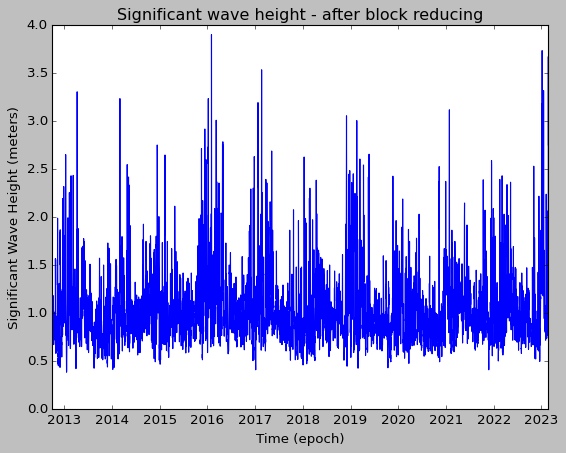

In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace=[999.0, 99.0, 9999.0], value=np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24, 1), func=np.mean).astype(float)
X = torch.tensor(using_sk[:-1, 0]).float().cuda()
y = torch.tensor(using_sk[:-1, 1]).float().cuda()
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


# Helper functions
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)


def add_new_kernel_term(original_kernel, new_kernel_term, operation):
    return str(original_kernel) + str(operation) + str(new_kernel_term)


# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
scaler_consts = [scaler_max, scaler_min, scale_factor]
print(f'Scale Max: {scaler_max}\n Scale Min: {scaler_min}\n Scale Factor: {scale_factor}')
temp_for_plotting = pd.Series(using_sk[:-1, 0] * 1e9, dtype='datetime64[ns]')
plt.plot(temp_for_plotting, using_sk[:-1, 1])
plt.xlabel("Time (epoch)")
plt.ylabel("Significant Wave Height (meters)")
plt.title(f'Significant wave height - after block reducing')
plt.show()

print(
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0, 0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1, 0])}\n'
    f'Number of Days: {df_as_np.shape[0] / 48}\n'
    f'Time Period (Days): {(df_as_np[-1, 0] - df_as_np[0, 0]) / 24 / 60 / 60}')

# Prediction range, training and test set define (14, 3, 365)
predict_days_out = 28
test_n = 2 * predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [3]:
data = data_compact
scale = scaler_consts

In [4]:
exact_gp_obj = TrainTestPlotSaveExactGP(
    ExactGPModel,
    kernel="RBF+RFF*AR2+Min",
    train_x=data[0], train_y=data[1], test_x=data[2], test_y=data[3],
    scaler_min=scale[1], scaler_max=scale[0],
    num_iter=1000,
    lr=0.01,
    name="RBF+RFF*AR2+Min",
    save_loss_values="save",
    use_scheduler=True)

Using available CUDA


Training exactGP: RBF+RFF*AR2+Min: 100%|██████████| 1000/1000 [15:56<00:00,  1.05it/s]


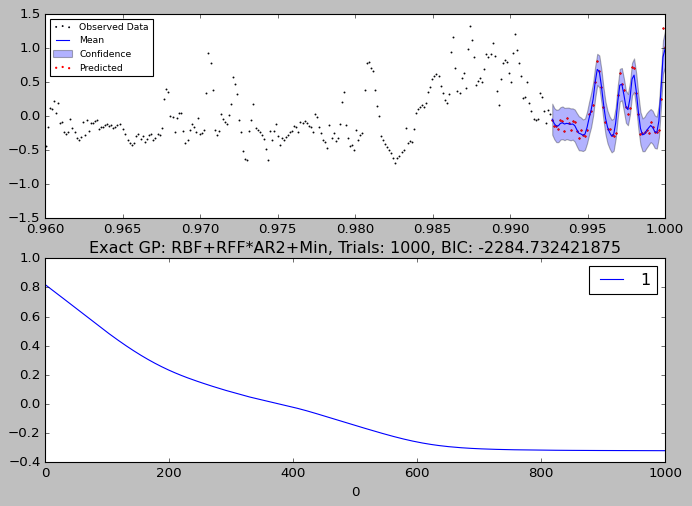

In [5]:
bic_at_current, hyper_vals = exact_gp_obj.run_train_test_plot_kernel(set_xlim=[0.96, 1])

In [6]:
n_total = exact_gp_obj.train_x.shape[0]

In [21]:
#idx_list = np.random.randint(n_total/2, n_total-6, size = 10000)
idx_list = np.random.randint(n_total/2, n_total-6, size = 100)

In [28]:
import time
start_time = time.time()

err_list = []

for idx_ahead in idx_list:
    print(iter)
    with torch.no_grad():
        # picks index in the second half of the observed data
        print(idx_ahead)

        # going to be the new "training" set; from t=0 to t=idx_ahead-1
        temp_x_train = exact_gp_obj.train_x[:idx_ahead]
        temp_y_train = exact_gp_obj.train_y[:idx_ahead]

        # this is the new "testing" set; t=idx_ahead, ..., idx_ahead+6
        temp_x_test = exact_gp_obj.train_x[idx_ahead:(idx_ahead+6)]
        temp_y_test = exact_gp_obj.train_y[idx_ahead:(idx_ahead+6)]
        exact_gp_obj.trained_model.set_train_data(inputs = temp_x_train, targets = temp_y_train, strict = False)

        exact_gp_obj.trained_model.eval()
        f = exact_gp_obj.trained_model(temp_x_test)

        err = torch.mean((f.mean - temp_y_test).pow(2)).item()

        err_list.append(err)

print("--- %s seconds ---" % (time.time() - start_time))

9
4351


RuntimeError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 11.00 GiB total capacity; 9.09 GiB already allocated; 0 bytes free; 9.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
# Recommendations:
# 1. Add "step_ahead_errors" as a method to the exact_gp_obj class.  input: idx_list, output: err_list
# 2. Generate idx_list, set seed first.  Then when you want the errors, you can feed it the same idx_list (fairness)
# 3. Compare across models, average over the respective err_list and compare
# Single out the top 2 models at each round, come up with these values.  Check for consistency with BIC

[0.014757944270968437,
 0.03790624067187309,
 0.18435102701187134,
 0.013863078318536282,
 0.025688670575618744,
 0.012399818748235703,
 0.09356001019477844,
 0.052731286734342575,
 0.17020659148693085,
 0.02476746402680874]